In [1]:
import requests
import pandas as pd
from rdkit import Chem
from concurrent.futures import ThreadPoolExecutor

In [2]:
headers = [
  "Index", "Name", "Synonym", "Structure", "Mol. form.", "CAS Reg. No.", "Beilstein Reg. No.", "Mol. wt.",
  "Physical form", "tmp/ºC", "tbp/ºC", "Other bp/ºC", "ρ/g cm-3",
  "nD", "s/g kg-1", "vp/kPa (25 °C)", "Solubility"
]
headers = [h.strip() for h in headers]
headers, len(headers)

(['Index',
  'Name',
  'Synonym',
  'Structure',
  'Mol. form.',
  'CAS Reg. No.',
  'Beilstein Reg. No.',
  'Mol. wt.',
  'Physical form',
  'tmp/ºC',
  'tbp/ºC',
  'Other bp/ºC',
  'ρ/g cm-3',
  'nD',
  's/g kg-1',
  'vp/kPa (25 °C)',
  'Solubility'],
 17)

In [3]:
df = pd.read_csv('crc_data_50.csv', names=headers, skiprows=1, index_col='Index')
df

,Name,Synonym,Structure,Mol. form.,CAS Reg. No.,Beilstein Reg. No.,Mol. wt.,Physical form,tmp/ºC,tbp/ºC,Other bp/ºC,ρ/g cm-3,nD,s/g kg-1,vp/kPa (25 °C),Solubility
Index,,,,,,,,,,,,,,,,
1,Abate,Temephos,NaN,C16H20O6P2S3,3383-96-8,NaN,466.469,cry,31.6(5),NaN,NaN,1.32,NaN,NaN,NaN,"sl H2O, hx; s ctc, eth, tol"
2,Abietic acid,Sylvic acid,NaN,C20H30O2,514-10-3,2221451.0,302.451,mcl pl (al-w),173.5,439.5,2509,1.0625,NaN,NaN,NaN,"vs ace, bz, eth, EtOH"
3,Abscisic acid,NaN,NaN,C15H20O4,21293-29-8,2698956.0,264.318,cry (chl-peth),160,120 subl,NaN,NaN,NaN,NaN,NaN,"vs ace, eth, chl"
4,Acacetin,"5,7-Dihydroxy-2-(4-methoxyphenyl)-4H-1-benzopy...",NaN,C16H12O5,480-44-4,277879.0,284.263,ye nd (95% al),263,NaN,NaN,NaN,NaN,NaN,NaN,vs EtOH
5,"Acebutolol, (±)-",NaN,NaN,C18H28N2O4,37517-30-9,NaN,336.426,cry,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bis(2-hydroxy-3-tert-butyl-5-methylphenyl)methane,NaN,NaN,C23H32O2,119-47-1,NaN,340.499,nd (peth),131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,Bis(2-hydroxy-5-chlorophenyl) sulfide,Fenticlor,NaN,C12H8Cl2O2S,97-24-5,2057140.0,287.162,NaN,174,NaN,NaN,NaN,NaN,NaN,NaN,"i H2O; s EtOH, eth, gl HOAc"
997,2-[Bis(2-hydroxyethyl)amino]ethanol hydrochloride,Triethanolamine hydrochloride,NaN,C6H16ClNO3,637-39-8,3909940.0,185.649,cry (al),179.5,NaN,NaN,NaN,NaN,NaN,NaN,vs H2O


SMILES for CAS 3383-96-8: COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(OC)OC


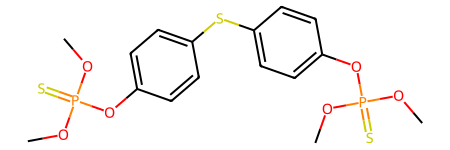

In [9]:
def get_smiles_from_cas(cas_number):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
        return smiles
    else:
        return None

cas_number = "3383-96-8"  # Example CAS number for water
smiles = get_smiles_from_cas(cas_number)
if smiles:
    print(f"SMILES for CAS {cas_number}: {smiles}")
    m = Chem.MolFromSmiles(smiles)
    display(m)
else:
    print(f"Could not retrieve SMILES for CAS {cas_number}")

In [11]:
cas_pattern = r'^\d{2,7}-\d{2}-\d$'
# Find invalid CAS numbers
invalid_cas = df[~df['CAS Reg. No.'].str.match(cas_pattern)]

# Display invalid CAS numbers
invalid_cas, df['CAS Reg. No.']

(Empty DataFrame
 Columns: [Name, Synonym, Structure, Mol. form., CAS Reg. No., Beilstein Reg. No., Mol. wt., Physical form, tmp/ºC, tbp/ºC, Other bp/ºC, ρ/g cm-3, nD, s/g kg-1, vp/kPa (25 °C), Solubility]
 Index: [],
 Index
 1       3383-96-8
 2        514-10-3
 3      21293-29-8
 4        480-44-4
 5      37517-30-9
           ...    
 995      119-47-1
 996       97-24-5
 997      637-39-8
 998      102-79-4
 999     1892-29-1
 Name: CAS Reg. No., Length: 999, dtype: object)

In [12]:
# Apply the function to each CAS number in the DataFrame
df['SMILES'] = df['CAS Reg. No.'].apply(get_smiles_from_cas)

# Display the DataFrame to verify changes
df

In [ ]:
# Define a function to apply get_smiles_from_cas in parallel
def apply_parallel(df, func, column_name):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, df[column_name]))
    return results

# Apply the function to each CAS number in the DataFrame in parallel
df['SMILES'] = apply_parallel(df, get_smiles_from_cas, 'CAS Reg. No.')

# Display the DataFrame to verify changes
df